# RRT: Rapidly expanding Random Tree

In [1]:
import numpy as np
import matplotlib.pyplot as plt

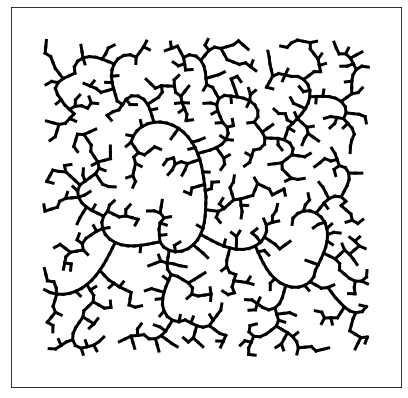

In [357]:
SEED = [0.5, 0.5]
N_POINTS = 1000
STEP_INITIAL = 0.02
STEP_DECREMENT = 0.8
MAX_FAILS = 10
CLOSE_PATHS = False
CURVE_TYPE = 'hook' # none, hook, or slide

tree = np.array(SEED, ndmin=2)

def nearest(tree,xy):
    dist2 = np.square(tree[:,0]-xy[0]) + np.square(tree[:,1]-xy[1])
    best = np.argmin(dist2)
    return (best,dist2[best])
    
fig = plt.figure(figsize=(7,7))
ax = plt.subplot(111)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.xticks(ticks=[])
plt.yticks(ticks=[])

def rot(alpha):
    return np.array([[np.cos(alpha),np.sin(alpha)],[-np.sin(alpha),np.cos(alpha)]])

count_failures = 0
step = STEP_INITIAL
current_width = 3
for i in range(N_POINTS):
    threshold = (step**2)/2                     # Collision threshold
    target = np.random.uniform(low=0, high=1, size=2)
    #plt.plot(target[0],target[1],'r.')
    
    best,_ = nearest(tree,target)    
    s = tree[best,:]
    vect = [target[0]-s[0], target[1]-s[1]]
    d = np.linalg.norm(vect)
    nsteps = int(d/step)
    vect = vect/d*step
    angle_coeff = 2*np.pi/(nsteps**2+1) # Presumably terminates at almost backwards
    angle_sign = 1 if np.random.uniform()>0.5 else -1
    if CURVE_TYPE == "slide":
        vect = np.matmul(rot(angle_sign*np.pi/2*step/STEP_INITIAL),vect)
        
    line = None
    for i in range(nsteps):
        old = s
        s = s+vect
        if CURVE_TYPE == "hook":
            vect = np.matmul(rot(angle_sign*i*angle_coeff),vect)
        elif CURVE_TYPE == 'slide':
            temp = i**2/nsteps**2
            vect = vect*(1-temp) + np.array([target[0]-s[0], target[1]-s[1]])*temp
        if s[0]<0 or s[0]>1 or s[1]<0 or s[1]>1:
            break
        (closest,d2) = nearest(tree,s)
        if d2<= threshold:
            if CLOSE_PATHS:
                line = np.vstack((line,tree[closest,:]))
                ax.plot([old[0],s[0]], [old[1],s[1]], 'k-', linewidth = current_width)
            break
        if line is None:
            line = s
        else:
            line = np.vstack((line,s))
        ax.plot([old[0],s[0]], [old[1],s[1]], 'k-', linewidth = current_width)
    if line is None:
        count_failures += 1
    else:
        tree = np.vstack((tree,line))
        count_failures = 0
    if count_failures == MAX_FAILS:
        step *= STEP_DECREMENT
        current_width *= STEP_DECREMENT
        print('.',end='')
    
    #plt.figure(figsize=(4,4))
    #plt.plot(tree[:,0],tree[:,1],'.')
    #plt.xlim(0,1)
    #plt.ylim(0,1)